In [ ]:
"""
https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/
"""


## Imports


Imports were successfully


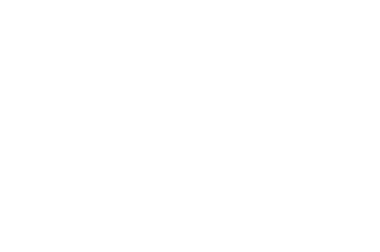

In [10]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import re
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

limits = plt.axis('off')
#nltk.download('stopwords')
#nltk.download('punkt')

print("Imports were successfully")

## Read the data


In [2]:
df = pd.read_csv('tennis_articles_v4.csv')
print(df.head())

print(df['article_text'][0])


   article_id                                       article_text  \
0           1  Maria Sharapova has basically no friends as te...   
1           2  BASEL, Switzerland (AP), Roger Federer advance...   
2           3  Roger Federer has revealed that organisers of ...   
3           4  Kei Nishikori will try to end his long losing ...   
4           5  Federer, 37, first broke through on tour over ...   

                                              source  
0  https://www.tennisworldusa.org/tennis/news/Mar...  
1  http://www.tennis.com/pro-game/2018/10/copil-s...  
2  https://scroll.in/field/899938/tennis-roger-fe...  
3  http://www.tennis.com/pro-game/2018/10/nishiko...  
4  https://www.express.co.uk/sport/tennis/1036101...  
Maria Sharapova has basically no friends as tennis players on the WTA Tour. The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much. I think everyone knows this is my job here

## Split the text into sentences


In [3]:
sentences = []
for s in df["article_text"]:
    t = sent_tokenize(s)
    for x in t:        
        sentences.append(x)
        
print("Total sentences:", len(sentences))
print(sentences[0])

Total sentences: 119
Maria Sharapova has basically no friends as tennis players on the WTA Tour.


## Download GloVe

In [7]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip


--2019-06-19 23:08:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-06-19 23:08:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-06-19 23:08:30--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

## Extract word vectors

In [4]:
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

print(len(word_embeddings))


400000


## Text processing


### Remove punctuations, numbers and special characters

In [5]:
#clean_sentences = pd.Series(sentences)#.str.replace("[^a-zA-Z]", " ")
clean_sentences = [s.replace("[^a-zA-Z]", " ") for s in sentences]

clean_sentences = [s.lower() for s in clean_sentences]
print(clean_sentences[:5])
print(len(clean_sentences))

['maria sharapova has basically no friends as tennis players on the wta tour.', "the russian player has no problems in openly speaking about it and in a recent interview she said: 'i don't really hide any feelings too much.", 'i think everyone knows this is my job here.', "when i'm on the courts or when i'm on the court playing, i'm a competitor and i want to beat every single person whether they're in the locker room or across the net.so i'm not the one to strike up a conversation about the weather and know that in the next few minutes i have to go and try to win a tennis match.", "i'm a pretty competitive girl."]
119


### Remove stop words

In [6]:
def remove_stopwords(sen):
    sen_new = " ".join([ i for i in sen if i not in stop_words])
    return sen_new

clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]
print(clean_sentences[:5])
print("Total clean sentences:",len(clean_sentences))


['maria sharapova basically friends tennis players wta tour.', "russian player problems openly speaking recent interview said: 'i really hide feelings much.", 'think everyone knows job here.', "i'm courts i'm court playing, i'm competitor want beat every single person whether they're locker room across net.so i'm one strike conversation weather know next minutes go try win tennis match.", "i'm pretty competitive girl."]
Total clean sentences: 119


## Vector Representation of Sentences


In [7]:

sentence_vectors = []
for i in clean_sentences:
    if len(i) != 0:
        # Generate averaged vector for the sentence given the words
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()]) / (len(i.split())+0.001)
    else:
        v = np.zeros((100,))
    
    sentence_vectors.append(v)

print("Sentence vectors:",len(sentence_vectors))

Sentence vectors: 119


## Similarity matrix


In [8]:
print("Total sentences:",len(sentences))
sim_mat = np.zeros([len(sentences), len(sentences)])
print("Sim Matrix shape:",sim_mat.shape)

for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100),
                                              sentence_vectors[j].reshape(1,100))[0,0]

print(sim_mat[0][0])        

Total sentences: 119
Sim Matrix shape: (119, 119)
0.0


## Applying Page Rank Algorithm

In [15]:
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)
        
print(scores)
print(len(scores))


{0: 0.008101364986246418, 1: 0.008583821019751912, 2: 0.00802660352416184, 3: 0.00944907043584545, 4: 0.007413633362498352, 5: 0.00832466396887694, 6: 0.008835857677327637, 7: 0.00829812992702863, 8: 0.008520768356946791, 9: 0.008262429417499004, 10: 0.0012695751770095795, 11: 0.008984590383960189, 12: 0.008341397163428792, 13: 0.00835373951676376, 14: 0.00865805706552805, 15: 0.008816091403481448, 16: 0.008036082244088468, 17: 0.007844737861434204, 18: 0.0080701728657931, 19: 0.009062146066825089, 20: 0.009166775776029146, 21: 0.007659546153814754, 22: 0.007621491338368544, 23: 0.009016449390182492, 24: 0.00872736451153825, 25: 0.006661574230054127, 26: 0.008516015837081378, 27: 0.009213871978565847, 28: 0.009395936178353116, 29: 0.009232733495543053, 30: 0.009475640462271, 31: 0.008743294680842794, 32: 0.008162816360574225, 33: 0.008612307975948164, 34: 0.008699521103307344, 35: 0.009031412303641156, 36: 0.007785139532161742, 37: 0.009151987752884626, 38: 0.009515460720166007, 39: 0.

## Summary Extraction

### Extract top-10 sentences as the summary

In [19]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
for i in range(10):
    print(ranked_sentences[i][0], ", ",ranked_sentences[i][1])



0.009515460720166007 ,  Major players feel that a big event in late November combined with one in January before the Australian Open will mean too much tennis and too little rest.
0.009475640462271 ,  Speaking at the Swiss Indoors tournament where he will play in Sundays final against Romanian qualifier Marius Copil, the world number three said that given the impossibly short time frame to make a decision, he opted out of any commitment.
0.009453598051279051 ,  "I felt like the best weeks that I had to get to know players when I was playing were the Fed Cup weeks or the Olympic weeks, not necessarily during the tournaments.
0.00944907043584545 ,  When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match.
0.009395936178353116 ,  Federer 